Based on model of scattering off dirac potential on sublattice A
Dutreix 2019

### Imports and Constants

In [41]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.special import hankel1
from scipy.integrate import quad
from scipy.optimize import fsolve
from scipy.ndimage import laplace

from tqdm import tqdm

In [42]:
%matplotlib inline

In [43]:
# This constant C is global and is used throughout the paper
# Other constants are from pybinding documentation on graphene
C = 1
VF = 906091185689731.9 #nm/s Speed of dirac fermions 
a = 0.24595 # nm Unit length cell of graphene
hbar = 6.582119569 * 1e-16 #eV s

V0 = -3 #eV Strength of the dirac potential
Vb = 0.2 #eV Bias voltage you integrate up to

ki = 2 # index of K and K prime valleys # 1
kpi = 0 # See below, the analytic model looks at adjacent valleys # 0

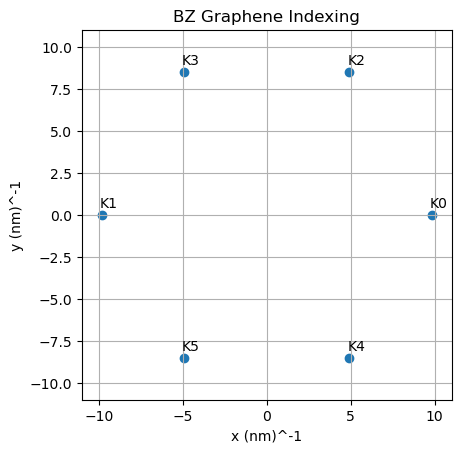

In [44]:
figt, axt = plt.subplots()

# Defining Graphene BZ

# From Graphene Tutorial
KC = (2 * np.pi) / (3 * a)

Kx, Ky = KC, KC * 1/np.sqrt(3)
KPx, KPy = KC, KC * -1/np.sqrt(3)

KR = np.sqrt(Kx ** 2 + Ky ** 2)

#kvals = np.array([[Kx, Ky], [-Kx, Ky], [0, -KR]])
#kpvals = np.array([[KPx, KPy], [-KPx, KPy], [0, KR]])
#val_labels = np.array([0, 1, 2])

#axt.scatter(kvals[:,0], kvals[:,1])
#axt.scatter(kpvals[:,0], kpvals[:,1])

#for i, label in enumerate(val_labels):
#    axt.annotate("K" + str(label), (kvals[:,0][i], kvals[:,1][i]), textcoords="offset points", xytext=(5, 5), ha='center')
#    axt.annotate("K'" + str(label), (kpvals[:,0][i], kpvals[:,1][i]), textcoords="offset points", xytext=(5, 5), ha='center')

# From Bena 2008
Kx = 1/a * np.array([4*np.pi/(3*np.sqrt(3)), -4*np.pi/(3*np.sqrt(3)), 2 * np.pi/(3 * np.sqrt(3)), -2 * np.pi/(3 * np.sqrt(3)), 2 * np.pi/(3 * np.sqrt(3)), -2 * np.pi/(3 * np.sqrt(3))])
Ky = 1/a * np.array([0, 0, 2*np.pi/3, 2*np.pi/3, -2*np.pi/3, -2*np.pi/3])

axt.scatter(Kx, Ky)

for i in range(0, 6):
    axt.annotate('K' + str(i), (Kx[i], Ky[i]), textcoords="offset points", xytext=(5, 5), ha='center')


axt.set_aspect("equal")
axt.set_xlim(-11, 11)
axt.set_ylim(-11, 11)
axt.set_xlabel("x (nm)^-1")
axt.set_ylabel("y (nm)^-1")
axt.set_title("BZ Graphene Indexing")
axt.grid()

### Local Density of States

In [45]:
# Greens function AA element for PRISTINE graphene
# Output units 1/[eV]
def G0AA(q, w):
    return -1/(w ** 2 - (VF * q)**2) * (-w)

# Transfer Function
#def t(w):
#    dem = 1 - V0/hbar * G0AA(0, w) # units
#    return V0/(dem*hbar)

# This has units [eV] if V0 is in [eV]
def t(w):
    dem = 1 - V0 * G0AA(0, w)
    return V0/(dem)

In [46]:
# w is the energy of the electrons
# We input Vb in units [eV] then divide by hbar [ev][s]
#def dRhoA(r, Vb):
#    return C * quad(lambda w: np.imag(w ** 2 * t(w) * hankel1(0, w * (r/VF)) ** 2), 0, Vb/(hbar))

#def dRhoB(r, Vb):
#    return C * quad(lambda w: np.imag(w ** 2 * t(w) * hankel1(1, w * (r/VF)) ** 2), 0, Vb/(hbar))

def dRhoA(r, Vb):
    return C * quad(lambda w: np.imag(w ** 2 * t(w) * hankel1(0, (w * r)/(VF * hbar)) ** 2), 0, Vb)

def dRhoB(r, Vb):
    return C * quad(lambda w: np.imag(w ** 2 * t(w) * hankel1(1, (w * r)/(VF * hbar)) ** 2), 0, Vb)

In [47]:
# Input in XY cartesian
# Bias voltage in eV
def LDOS(DK, R, Vb, valley):

    r = np.sqrt(R[0] ** 2 + R[1] ** 2)
    thet = np.arctan(R[1]/R[0])

    return dRhoA(r, Vb)[0] * np.cos(np.dot(DK, R)) - dRhoB(r, Vb)[0] * np.cos(np.dot(DK, R) - 2 * valley * thet)

In [48]:
xlin = np.linspace(-5, 5, 300)
ylin = np.linspace(-5, 5, 300)

xx, yy = np.meshgrid(xlin, ylin)

# From paper connects two ADJACENT dirac points
#DK = [KPx - Kx, KPy - Ky]

#DK = [kvals[ki][0] - kpvals[kpi][0], kvals[ki][1] - kpvals[kpi][1]]

# From Bena 2008
DK = [Kx[3]-Kx[1], Ky[3]-Ky[1]]

# From pybinding FFT
#DK = [1.36, 2.35] #nm ^-1

# From Liu et Al
#a_cc = 0.142 #nm
#DK = [-(4 * np.pi)/(3*np.sqrt(3)*a_cc), 0]


# Density multiplies by R**2 to enhance distance visibility
zz = [(x **2 + y ** 2) * LDOS(DK, [x, y], Vb, 1) for x,y in tqdm(zip(xx.flatten(), yy.flatten()))]

zz = np.array(zz).reshape(len(xlin), len(ylin))


0it [00:00, ?it/s]

90000it [00:12, 7213.87it/s]


Try to mathematically find the dislocations

We are using eqn S16 there are two sets of angle and radius values that solve

In [49]:
# RhoA = RhoB
# No minus sign here, so it seems RhoB is defined correctly
def cond1(r):
    normal = dRhoA(0.14, Vb)[0]
    return 1/normal * (dRhoA(r, Vb)[0] - (1) * dRhoB(r, Vb)[0])

# RhoA = -RhoB
def cond2(r):
    normal = dRhoA(0.14, Vb)[0]
    return 1/normal * (dRhoA(r, Vb)[0] + (1) * dRhoB(r, Vb)[0])

In [50]:
def rotv(vector, theta):
    
    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]])

    return np.dot(rotation_matrix, vector)

In [51]:
# Value of Dislocation
# The angle phi is of vec(r) with respect to DeltaK so we make relative to x axis
r1 = fsolve(cond1, 3)
#valley * 0 or valley * pi
phi1 = [0, np.pi]

r2 = fsolve(cond2, 3)
# plus or minus pi/ times valley
phi2 = [np.pi/2, -np.pi/2]

theta1 = np.arctan2(DK[1], DK[0]) + phi1[0]
theta2 = np.arctan2(DK[1], DK[0]) + phi2[0]

In [52]:
DK[1]/DK[0]

1.7320508075688774

(-20.0, 20.0)

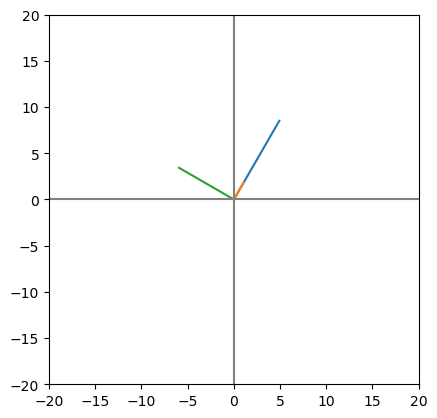

In [53]:
fig7, ax7 = plt.subplots()

r1x, r1y = r1 * np.cos(theta1), r1 * np.sin(theta1)
r2x, r2y = r2 * np.cos(theta2), r2 * np.sin(theta2)


ax7.plot([0, DK[0]], [0, DK[1]])
ax7.plot([0, r1x[0]], [0, r1y[0]])
ax7.plot([0, r2x[0]], [0, r2y[0]])
ax7.axhline(0, c="grey")
ax7.axvline(0, c="grey")
ax7.set_aspect("equal")
ax7.set_xlim(-20, 20)
ax7.set_ylim(-20, 20)

Text(0.5, 0.98, 'LDOS for V0 = -3.00 eV, Vb = 0.20 ev')

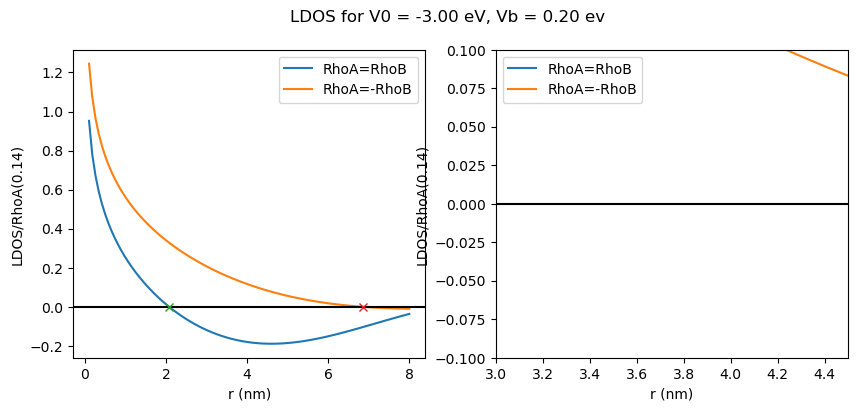

In [54]:
fig5, axs5 = plt.subplots(1, 2, figsize=(10, 4))

rlist = np.linspace(0.1, 8, 100) # nm

ycond1 = np.array([cond1(ri) for ri in rlist])
ycond2 = np.array([cond2(ri) for ri in rlist])

axs5[0].plot(rlist, ycond1)
axs5[0].plot(rlist, ycond2)
axs5[0].axhline(0, color="black")
axs5[0].legend(['RhoA=RhoB', 'RhoA=-RhoB'])
axs5[0].set_xlabel("r (nm)")
axs5[0].set_ylabel("LDOS/RhoA(0.14)")

axs5[1].plot(rlist, ycond1)
axs5[1].plot(rlist, ycond2)
axs5[1].axhline(0, color="black")
axs5[1].legend(['RhoA=RhoB', 'RhoA=-RhoB'])
axs5[1].set_xlabel("r (nm)")
axs5[1].set_ylabel("LDOS/RhoA(0.14)")
axs5[1].set_xlim(3, 4.5)
axs5[1].set_ylim(-0.1, 0.1)

axs5[0].plot(r1, 0, marker="x")
axs5[0].plot(r2, 0, marker="x")

axs5[1].plot(r1, 0, marker="x")
axs5[1].plot(r2, 0, marker="x")

#axs5.set_title(f"LDOS for V0 = {V0:.2f} eV, Vb = {thisVB:.2f} ev")

fig5.suptitle(f"LDOS for V0 = {V0:.2f} eV, Vb = {Vb:.2f} ev")

In [55]:
-DK[0]/DK[1]

-0.5773502691896257

(-5.0, 5.0)

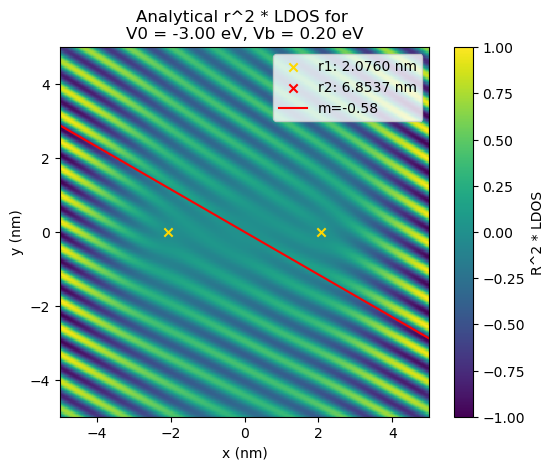

In [56]:
fig2, ax2 = plt.subplots()

# Normalized to from between -1 and 1
minval, maxval = np.min(zz), np.max(zz)

zzn = (zz - minval)/(maxval-minval) # Normalize
zzn = 2 * zzn - 1 # Normalize to -1 1

#ax2.scatter(xx.flatten(), yy.flatten(), c=zz)
c = ax2.pcolormesh(xx, yy, zzn)
fig2.colorbar(c, ax=ax2, label="R^2 * LDOS")
ax2.set_aspect('equal')
ax2.set_xlabel("x (nm)")
ax2.set_ylabel("y (nm)")
ax2.set_title(f"Analytical r^2 * LDOS for \nV0 = {V0:.2f} eV, Vb = {Vb:.2f} eV")

# Adding calculated dislocation point case1
xd1, xd2 = r1 * np.cos(phi1[0]), r1 * np.cos(phi1[1])
yd1, yd2 = r1 * np.sin(phi1[0]), r1 * np.sin(phi1[1])
ax2.scatter([xd1, xd2], [yd1, yd2], color='gold', marker='x')

# Adding calculated dislocation point case2
xd1, xd2 = r2 * np.cos(phi2[0]), r2 * np.cos(phi2[1])
yd1, yd2 = r2 * np.sin(phi2[0]), r2 * np.sin(phi2[1])
ax2.scatter([xd1, xd2], [yd1, yd2], color='red', marker='x')

m1, b1 = -0.577, 0
xlinf = np.linspace(-5, 5, 100)
ax2.plot(xlinf, m1 * xlinf + b1, 'red')

ax2.legend([f"r1: {r1[0]:.4f} nm", f"r2: {r2[0]:.4f} nm", f"m={m1:.2f}"])

ax2.set_xlim(-5, 5)
ax2.set_ylim(-5, 5)

In [57]:
print(f"r1: {r1[0]:.4f} r2: {r2[0]:.4f}")

r1: 2.0760 r2: 6.8537


In [58]:
DK

[4.916444708908904, 8.515532028433402]

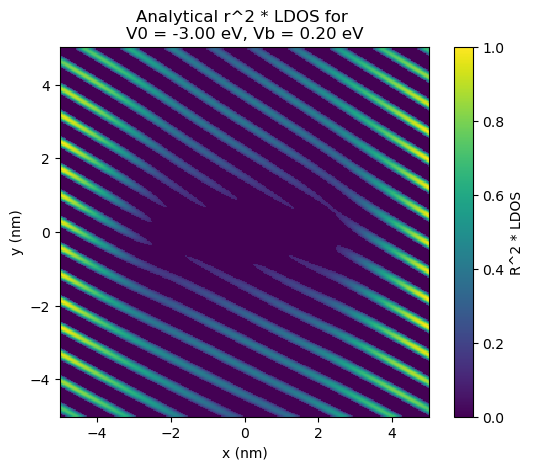

In [59]:
# Laplacian

fig8, ax8 = plt.subplots()

mask = zzn < 0.1
zzn_masked = np.where(mask, 0, zzn)

c = ax8.pcolormesh(xx, yy, zzn_masked)
fig8.colorbar(c, ax=ax8, label="R^2 * LDOS")
ax8.set_aspect('equal')
ax8.set_xlabel("x (nm)")
ax8.set_ylabel("y (nm)")
ax8.set_title(f"Analytical r^2 * LDOS for \nV0 = {V0:.2f} eV, Vb = {Vb:.2f} eV")

plt.show()

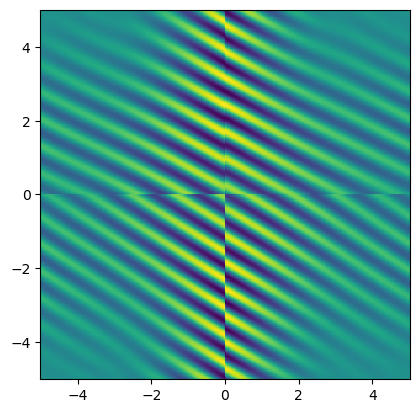

In [60]:
# Try an FFT
fig6, ax6 = plt.subplots()

ftz = np.fft.ifft2(zz) # Remember this is LDOS times r**2
ftz = np.fft.ifftshift(zz)

# Log scale height
plz = np.log(np.abs(ftz ** 2))

ax6.set_aspect('equal')

ax6.pcolormesh(xx, yy, ftz)